In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import argparse
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
import glob
import os

In [37]:
dir = '/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/'
dir = '/Users/smurugan9/research/aislens/MALI-ismip6-0721/hist_08/output/'

'floatingBasalMassBalApplied'

'floatingBasalMassBalApplied'

In [40]:
tmpdir = '/Users/smurugan9/research/aislens/aislens_emulation/data/interim/MALI_runs/ismip6-1108/hist04/globalStats.nc'
tmpds = xr.open_dataset(tmpdir)

In [51]:
hist = '/Users/smurugan9/research/aislens/aislens_emulation/data/interim/MALI_runs/ismip6-1108/hist04/'
ctrl = '/Users/smurugan9/research/aislens/aislens_emulation/data/interim/MALI_runs/ismip6-1108/ctrlAE_04/'
exp01 = '/Users/smurugan9/research/aislens/aislens_emulation/data/interim/MALI_runs/ismip6-1108/expAE01_04/'

In [52]:
globalStats = 'globalStats.nc'
regionalStats = 'regionalStats.nc'

In [56]:
ctrlRegional = xr.open_dataset(ctrl+regionalStats)
exp01Regional = xr.open_dataset(exp01+regionalStats)

#ctrlglobal = xr.open_dataset(ctrl+globalStats)
exp01global = xr.open_dataset(exp01+globalStats)

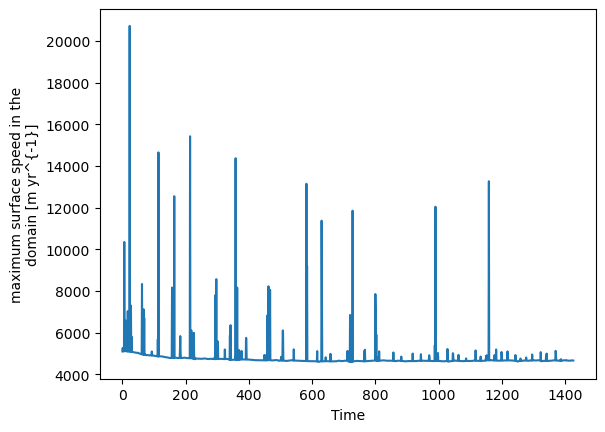

In [62]:
exp01global.surfaceSpeedMax.plot()

In [18]:
dir1 = '/Users/smurugan9/research/aislens/aislens_emulation/data/interim/MALI_runs/ismip6_obs23_IC/globalStats.nc'
dir2 = '/Users/smurugan9/research/aislens/aislens_emulation/data/interim/MALI_runs/ismip6-relax/globalStats.nc'
dir3 = '/Users/smurugan9/research/aislens/aislens_emulation/data/interim/MALI_runs/ismip6-1101-obs23/globalStats.nc'

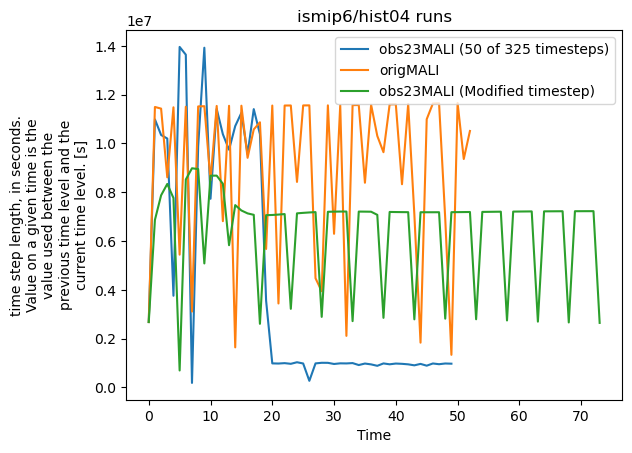

In [45]:
ds = xr.open_dataset(dir1)
ds2 = xr.open_dataset(dir2)
ds3 = xr.open_dataset(dir3)
ds.deltat[:50].plot(label='obs23MALI (50 of 325 timesteps)')
ds2.deltat.plot(label='origMALI')
tmpds.deltat.plot(label='obs23MALI (Modified timestep)')
#ds3.deltat[:50].plot(label='obs23-1101-MALI')
plt.title('ismip6/hist04 runs')
plt.legend()

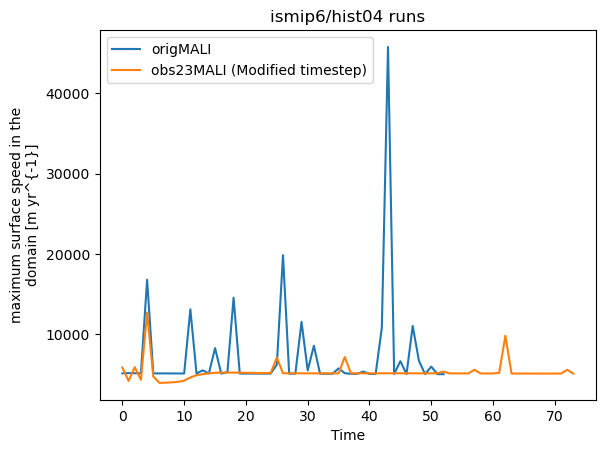

In [50]:
#ds.surfaceSpeedMax[:50].plot(label='obs23MALI (100 of 325 timesteps)')
ds2.surfaceSpeedMax.plot(label='origMALI')
tmpds.surfaceSpeedMax.plot(label='obs23MALI (Modified timestep)')
#ds3.deltat[:50].plot(label='obs23-1101-MALI')
plt.title('ismip6/hist04 runs')
plt.legend()

In [45]:
ds.data_vars

Data variables:
    xtime                           (Time) |S64 b'2015-01-01_00:00:00'
    simulationStartTime             |S64 b'2000-01-01_00:00:00'
    damage                          (Time, nCells) float64 0.0 0.0 ... 0.1576
    calvingThickness                (Time, nCells) float64 0.0 0.0 ... 0.0 0.0
    calvingThicknessFromThreshold   (Time, nCells) float64 0.0 0.0 ... 0.0 0.0
    calvingVelocity                 (Time, nCells) float64 0.0 0.0 ... 0.0 0.0
    surfaceSpeed                    (Time, nCells) float64 0.0 0.0 ... 1.131e-05
    daysSinceStart                  (Time) timedelta64[ns] 5475 days
    cellMask                        (Time, nCells) int32 0 0 0 0 ... 0 99 0 103
    sfcMassBalApplied               (Time, nCells) float64 0.0 0.0 ... 2.165e-05
    floatingBasalMassBalApplied     (Time, nCells) float64 0.0 ... -9.734e-05
    groundedBasalMassBalApplied     (Time, nCells) float64 0.0 0.0 ... 0.0 0.0
    deltat                          (Time) float64 1.369e+07
    f

In [34]:
for ii, run in enumerate(sorted(glob.glob(dir+"*.nc"))):
    (path, inFileName) = os.path.split(run)
    print(run)

/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/Regridded_SORRMv2.1.ISMF.0001-0099.6000.0x6000.0km_10.0km_Antarctic_stereo.nc
/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/Regridded_SORRMv2.1.ISMF.0100-0199.6000.0x6000.0km_10.0km_Antarctic_stereo.nc
/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/Regridded_SORRMv2.1.ISMF.0200-0299.6000.0x6000.0km_10.0km_Antarctic_stereo.nc
/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/Regridded_SORRMv2.1.ISMF.0300-0399.6000.0x6000.0km_10.0km_Antarctic_stereo.nc
/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/Regridded_SORRMv2.1.ISMF.0400-0499.6000.0x6000.0km_10.0km_Antarctic_stereo.nc
/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/Regridded_SORRMv2.1.IS

In [19]:
figs = {}
figs[run] = plt.figure()

<Figure size 640x480 with 0 Axes>